# Face Recognition Using Siamese Network

We will understand the siamese network by building the face recognition model. The objective of our network is to understand whether two faces are similar or dissimilar. We use AT & T's the Database of Faces which can be downloaded from [here](https://www.kaggle.com/datasets/kasikrit/att-database-of-faces)

Once you have downloaded and extracted the archive, you can see the folders like s1, s2 up to s40 as shown here:

Each of these folders has 10 different images of a single person taken from various angles. For an instance, let us open folder s1. As you can see, there are 10 different images of a single person:

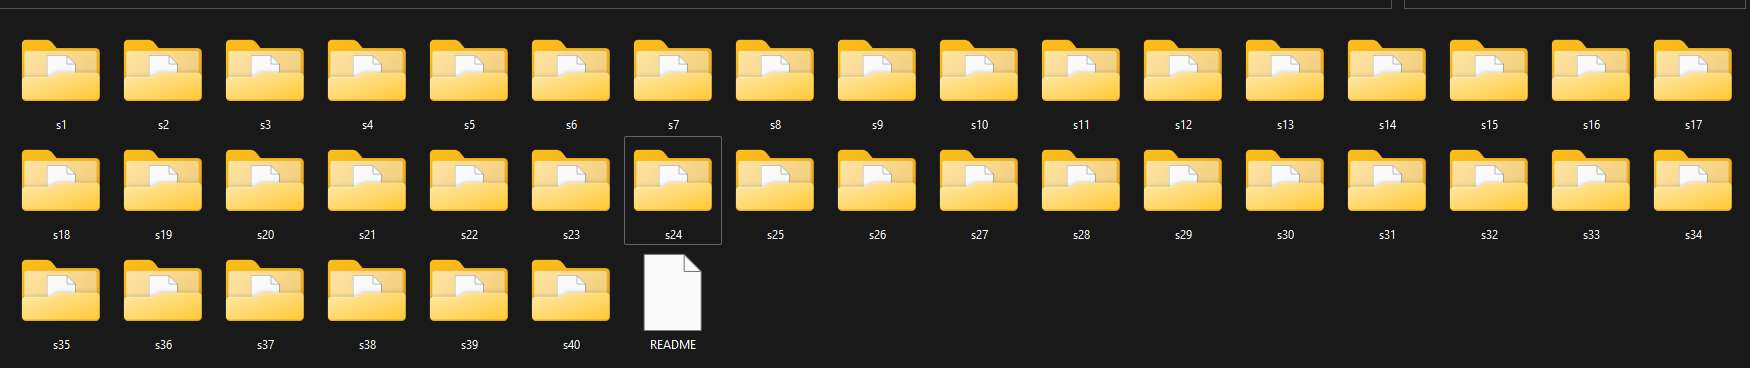

We will open and check folder s13,

As we know that siamese networks require inputs as a pair along with the label, we have to create our data in such a way. So we will take two images randomly from the same folder and mark it as a genuine pair and we will take a single image from two different folders and mark them as an imposite pair. A sample data is shown in the below figure, as you can notice a genuine pair has images of the same person and imposite pair has images of a different person.

Once we have our data as pairs along with their labels, we train our siamese network. From the image pair, we feed one image to the network A and another image to the network B. The role of these two networks is only to extract the feature vectors. So, we use two convolution layers with relu activations for extracting the features. Once we have learned the feature, we feed the resultant feature vector from both of the networks to the energy function which measures the similarity,  we use Euclidean distance as our energy function. So, we train our network by feeding the image pair to learn the semantic similarity between them.  Now, we will see this step by step.


First, we will import the required libraries.

In [1]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

Now, we define a function for reading our input image. The function read_image takes input as an image and returns the numpy array.

In [3]:
def read_image(filename, byteorder='>'):

    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()

    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()

    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))



#### First unzip the archive we got from kaggle

For an example, Let us open one image,

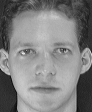

In [11]:
Image.open("./data/faces_at_t/s1/1.pgm")

When we feed this image to our read_image function, it will return as the numpy array,

In [12]:
img = read_image('./data/faces_at_t/s1/1.pgm')

In [13]:
img.shape

(112, 92)

Now, we define another function get_data for generating our data. As we know, for the Siamese network, data should be in the form of pairs (genuine and imposite) with a binary label.

First, we read the images (img1, img2) from the same directory and store them in the x_genuine_pair array and assign y_genuine to 1. Next, we read the images (img1, img2) from the different directory and store them in the x_imposite pair and assign y_imposite to 0.

Finally, we concatenate both x_genuine_pair, x_imposite to X and y_genuine, y_imposite to Y:

In [16]:
size = 2
total_sample_size = 10000


def get_data(size, total_sample_size):
    #read the image
    image = read_image('./data/faces_at_t/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    #reduce the size
    image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0

    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])  # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])

    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0

            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)

            # read the two images
            img1 = read_image('./data/faces_at_t/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image('./data/faces_at_t/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')

            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2

            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])

    for i in range(int(total_sample_size/10)):
        for j in range(10):

            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break

            img1 = read_image('./data/faces_at_t/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image('./data/faces_at_t/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1

    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

Now, we generate our data and check our data size. As you can see we have 20,000 data points, out of these 10,000 are genuine pairs and 10,000 are imposite pairs.

In [17]:
X, Y = get_data(size, total_sample_size)

In [18]:
print(type(X), len(X))

<class 'numpy.ndarray'> 20000


In [21]:
X.shape

(20000, 2, 1, 56, 46)

Next, we split our data for training and testing with 75% training and 25% testing proportions:

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

Now that, we have successfully generated our data, we build our siamese network. First, we define the base network which is basically a convolutional network used for feature extraction. We build two convolutional layers with rectified linear unit (ReLU) activations and max pooling followed by flat layer.

In [23]:
def build_base_network(input_shape):

    seq = Sequential()

    nb_filter = [6, 12]
    kernel_size = 3


    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,
                          padding='valid', data_format='channels_first')) # replaced border_mode with padding, dim_ordering='th' replaced with data_format='channels_first'
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    seq.add(Dropout(.25))

    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
    seq.add(Dropout(.25))

    #flatten
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq


Next, we feed the image pair, to the base network, which will return the embeddings that is, feature vectors:

In [24]:
input_dim = x_train.shape[2:]
print("Input shape", input_dim)

img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

Input shape (1, 56, 46)


In [25]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

These feat_vecs_a and feat_vecs_b are the feature vectors of our image pair. Next, we feed this feature vectors to the energy function to compute the distance between them, we use Euclidean distance as our energy function.

In [26]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [27]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

 Now, we set the epoch length to 13 and we use RMS prop for optimization and define our model.

In [277]:
img_1 = x_train[:, 0]
img2 = x_train[:, 1]

In [278]:
model.fit([img_1, img2], y_train, validation_split=.25,
          batch_size=128, verbose=2, epochs=epochs) # replace nb_epoch with epochs

Epoch 1/50
88/88 - 2s - loss: 0.2537 - val_loss: 0.3955 - 2s/epoch - 21ms/step
Epoch 2/50
88/88 - 1s - loss: 0.2473 - val_loss: 0.3779 - 703ms/epoch - 8ms/step
Epoch 3/50
88/88 - 1s - loss: 0.2426 - val_loss: 0.3363 - 693ms/epoch - 8ms/step
Epoch 4/50
88/88 - 1s - loss: 0.2339 - val_loss: 0.2951 - 656ms/epoch - 7ms/step
Epoch 5/50
88/88 - 1s - loss: 0.2224 - val_loss: 0.2506 - 562ms/epoch - 6ms/step
Epoch 6/50
88/88 - 1s - loss: 0.2090 - val_loss: 0.2215 - 562ms/epoch - 6ms/step
Epoch 7/50
88/88 - 1s - loss: 0.2018 - val_loss: 0.1945 - 559ms/epoch - 6ms/step
Epoch 8/50
88/88 - 0s - loss: 0.1933 - val_loss: 0.1873 - 496ms/epoch - 6ms/step
Epoch 9/50
88/88 - 1s - loss: 0.1889 - val_loss: 0.1916 - 517ms/epoch - 6ms/step
Epoch 10/50
88/88 - 0s - loss: 0.1807 - val_loss: 0.1638 - 493ms/epoch - 6ms/step
Epoch 11/50
88/88 - 1s - loss: 0.1788 - val_loss: 0.1606 - 556ms/epoch - 6ms/step
Epoch 12/50
88/88 - 0s - loss: 0.1731 - val_loss: 0.1580 - 483ms/epoch - 5ms/step
Epoch 13/50
88/88 - 1s - lo

Now, we make predictions with test data

In [32]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

InvalidArgumentError: Graph execution error:

Detected at node 'model/sequential/max_pooling2d_1/MaxPool' defined at (most recent call last):
    File "C:\Users\abhinav.m\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\abhinav.m\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\abhinav.m\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\abhinav.m\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\abhinav.m\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\abhinav.m\AppData\Local\Temp\ipykernel_4460\1219677665.py", line 1, in <module>
      pred = model.predict([x_test[:, 0], x_test[:, 1]])
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\engine\training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
      return self(x, training=False)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\engine\sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\abhinav.m\Desktop\abhi\code\Projects\face-recognition\.venv\lib\site-packages\keras\src\layers\pooling\base_pooling2d.py", line 84, in call
      outputs = self.pool_function(
Node: 'model/sequential/max_pooling2d_1/MaxPool'
Default MaxPoolingOp only supports NHWC on device type CPU
	 [[{{node model/sequential/max_pooling2d_1/MaxPool}}]] [Op:__inference_predict_function_400]

In [ ]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

Finally, we check our model accuracy.

In [ ]:
compute_accuracy(pred, y_test)

0.8059244126659857

### Testing with images

In [282]:
img1_path = "/content/dataset/s13/1.pgm"
img2_path = "/content/dataset/s13/1.pgm"

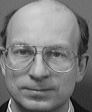

In [283]:
Image.open(img1_path)

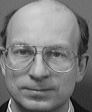

In [284]:
Image.open(img2_path)

In [285]:
img1 = read_image(img1_path)
img2 = read_image(img2_path)

In [286]:
print(type(img1))

<class 'numpy.ndarray'>


In [287]:
dim1 = img1.shape[0]
dim2 = img1.shape[1]
dim1,dim2

(112, 92)

In [288]:
img1 = img1[::size, ::size]
img2 = img2[::size, ::size]

In [292]:
print(img1.shape)

(56, 46)


In [294]:
x_geuine_pair = np.zeros([1, 2, 1, dim1, dim2])
x_imposite_pair = np.zeros([1, 2, 1, dim1, dim2])

In [295]:
count = 0
x_geuine_pair[count, 0, 0, :, :] = img1
x_imposite_pair[count, 1, 0, :, :] = img2

ValueError: ignored

In [ ]:
pred = model.predict([x_geuine_pair[:, 0], x_imposite_pair[:, 1]])

Finally, we check our model accuracy.

In [ ]:
pred[0]

# Different images

In [ ]:
img1_path = "/content/dataset/s13/1.pgm"
img2_path = "/content/dataset/s13/3.pgm"

In [ ]:
Image.open(img1_path)

In [ ]:
Image.open(img2_path)

In [ ]:
img1 = read_image(img1_path)
img2 = read_image(img2_path)

In [ ]:
img1 = img1[::size, ::size]
img2 = img2[::size, ::size]

In [ ]:
x_geuine_pair = np.zeros([1, 2, 1, dim1, dim2])
x_imposite_pair = np.zeros([1, 2, 1, dim1, dim2])

In [ ]:
count = 0
x_geuine_pair[count, 0, 0, :, :] = img1
x_imposite_pair[count, 1, 0, :, :] = img2

In [ ]:
pred = model.predict([x_geuine_pair[:, 0], x_imposite_pair[:, 1]])

Finally, we check our model accuracy.

In [ ]:
pred[0]

In [ ]:
dim1, dim2

### Compare with a bunch of images

In [296]:
def process_image(path: str, existing: bool):
  image = read_image(path)
  image = image[::2, ::2]

  x = np.zeros([1, 2, 1, 56, 46])

  if existing:
    axis = 1
  else:
    axis = 0
  x[0, axis, 0, :, :] = image
  return x

In [297]:
new_img_path = "/content/dataset/s13/1.pgm"
new_img = process_image(new_img_path, False)
for i in range(1,10):
  compare_img = process_image(f"/content/dataset/s13/{i}.pgm", True)
  pred = model.predict([new_img[:, 0], compare_img[:, 1]])
  print(f"Comparing Image 1 with Image {i} Score - {pred[0][0]:.3f}")

1/1 [==============================] - 0s 21ms/step
Comparing Image 1 with Image 1 Score - 0.000
1/1 [==============================] - 0s 20ms/step
Comparing Image 1 with Image 2 Score - 4.553
1/1 [==============================] - 0s 21ms/step
Comparing Image 1 with Image 3 Score - 8.209
1/1 [==============================] - 0s 19ms/step
Comparing Image 1 with Image 4 Score - 6.196
1/1 [==============================] - 0s 18ms/step
Comparing Image 1 with Image 5 Score - 4.207
1/1 [==============================] - 0s 18ms/step
Comparing Image 1 with Image 6 Score - 6.781
1/1 [==============================] - 0s 18ms/step
Comparing Image 1 with Image 7 Score - 4.762
1/1 [==============================] - 0s 21ms/step
Comparing Image 1 with Image 8 Score - 4.524
1/1 [==============================] - 0s 18ms/step
Comparing Image 1 with Image 9 Score - 9.642


### Compare one image a bunch of others

In [298]:
new_img_path = "/content/dataset/s13/1.pgm"
# img_show = Image.open(new_img_path)
new_img = process_image(new_img_path, False)
for i in range(1,10):
  compare_img = process_image(f"/content/dataset/s14/{i}.pgm", True)
  pred = model.predict([new_img[:, 0], compare_img[:, 1]])
  print(f"Comparing Image 1 with Image {i} Score - {pred[0][0]:.3f}")
  # img_show.show()

1/1 [==============================] - 0s 29ms/step
Comparing Image 1 with Image 1 Score - 46.268
1/1 [==============================] - 0s 27ms/step
Comparing Image 1 with Image 2 Score - 51.754
1/1 [==============================] - 0s 30ms/step
Comparing Image 1 with Image 3 Score - 51.744
1/1 [==============================] - 0s 30ms/step
Comparing Image 1 with Image 4 Score - 47.720
1/1 [==============================] - 0s 28ms/step
Comparing Image 1 with Image 5 Score - 50.297
1/1 [==============================] - 0s 27ms/step
Comparing Image 1 with Image 6 Score - 153.976
1/1 [==============================] - 0s 30ms/step
Comparing Image 1 with Image 7 Score - 116.690
1/1 [==============================] - 0s 30ms/step
Comparing Image 1 with Image 8 Score - 146.752
1/1 [==============================] - 0s 21ms/step
Comparing Image 1 with Image 9 Score - 119.597


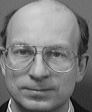

In [299]:
Image.open("/content/dataset/s13/1.pgm")

In [ ]:
Image.open("/content/dataset/s14/2.pgm")